In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
df_ = pd.read_csv('flo_data_20k.csv')
df = df_.copy()

In [3]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0,3.110855,4.225647,1.00,1.00,2.00,4.00,200.00
order_num_total_ever_offline,19945.0,1.913913,2.062880,1.00,1.00,1.00,2.00,109.00
customer_value_total_ever_offline,19945.0,253.922597,301.532853,10.00,99.99,179.98,319.97,18119.14
customer_value_total_ever_online,19945.0,497.321690,832.601886,12.99,149.98,286.46,578.44,45220.13


In [5]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [6]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)

In [7]:
replace_with_thresholds(df, 'customer_value_total_ever_offline')
replace_with_thresholds(df, 'customer_value_total_ever_online')

replace_with_thresholds(df, 'order_num_total_ever_online')
replace_with_thresholds(df, 'order_num_total_ever_offline')

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0,3.091953,3.809541,1.00,1.00,2.00,4.00,48.0
order_num_total_ever_offline,19945.0,1.886187,1.434694,1.00,1.00,1.00,2.00,16.0
customer_value_total_ever_offline,19945.0,251.921320,251.023670,10.00,99.99,179.98,319.97,3020.0
customer_value_total_ever_online,19945.0,489.705676,632.609844,12.99,149.98,286.46,578.44,7800.0


In [9]:
df['order_num_total'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['customer_value_total'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']

In [10]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],5.0,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.0,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",5.0,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.0,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],2.0,209.98


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [12]:
for col in df.columns:
    if 'date' in col:
        df[col] = pd.to_datetime(df[col])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

In [14]:
last_order_date_max = dt.datetime.strptime(str(df['last_order_date'].max()), '%Y-%m-%d %H:%M:%S')

In [15]:
df['last_order_date'].max()

Timestamp('2021-05-30 00:00:00')

In [16]:
today_date = last_order_date_max + dt.timedelta(days=2)
today_date

datetime.datetime(2021, 6, 1, 0, 0)

In [17]:
cltv_df = df[['master_id', 'last_order_date', 'first_order_date', 'order_num_total', 'customer_value_total']]
cltv_df

,master_id,last_order_date,first_order_date,order_num_total,customer_value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2021-02-26,2020-10-30,5.0,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2021-02-16,2017-02-08,21.0,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,2020-11-27,2019-11-27,5.0,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-17,2021-01-06,2.0,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2021-03-07,2019-08-03,2.0,209.98
...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,2020-07-05,2019-09-21,3.0,401.96
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,2020-12-22,2020-03-01,2.0,390.47
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,2021-05-24,2019-09-11,3.0,632.94
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,2021-02-13,2019-03-27,6.0,1009.77


In [18]:
cltv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   master_id             19945 non-null  object        
 1   last_order_date       19945 non-null  datetime64[ns]
 2   first_order_date      19945 non-null  datetime64[ns]
 3   order_num_total       19945 non-null  float64       
 4   customer_value_total  19945 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(1)
memory usage: 779.2+ KB


In [19]:
# recency: Time, since last user-specific purchase on a weekly basis
# T: how long before the first purchase was made the analysis date (the age of the customer on a weekly basis)
# frequency: total number of repeat purchases (frequency>1)
# monetary: average earnings per purchase

In [20]:
cltv_df['recency'] = (cltv_df['last_order_date'] - cltv_df['first_order_date']).dt.days / 7

In [21]:
cltv_df['T'] = (today_date - cltv_df['first_order_date']).dt.days / 7

In [22]:
cltv_df.rename(columns={'order_num_total': 'frequency'}, inplace=True)
cltv_df = cltv_df[cltv_df['frequency'] > 1]

In [23]:
cltv_df['monetary'] = cltv_df['customer_value_total'] / cltv_df['frequency']

In [24]:
cltv_df

,master_id,last_order_date,first_order_date,frequency,customer_value_total,recency,T,monetary
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2021-02-26,2020-10-30,5.0,939.37,17.000000,30.571429,187.874000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2021-02-16,2017-02-08,21.0,2013.55,209.857143,224.857143,95.883333
2,69b69676-1a40-11ea-941b-000d3a38a36f,2020-11-27,2019-11-27,5.0,585.32,52.285714,78.857143,117.064000
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-17,2021-01-06,2.0,121.97,1.571429,20.857143,60.985000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2021-03-07,2019-08-03,2.0,209.98,83.142857,95.428571,104.990000
...,...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,2020-07-05,2019-09-21,3.0,401.96,41.142857,88.428571,133.986667
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,2020-12-22,2020-03-01,2.0,390.47,42.285714,65.285714,195.235000
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,2021-05-24,2019-09-11,3.0,632.94,88.714286,89.857143,210.980000
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,2021-02-13,2019-03-27,6.0,1009.77,98.428571,113.857143,168.295000


In [25]:
cltv_df = cltv_df[['master_id', 'recency', 'T', 'frequency', 'monetary']]
cltv_df

,master_id,recency,T,frequency,monetary
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000000,30.571429,5.0,187.874000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857143,224.857143,21.0,95.883333
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.285714,78.857143,5.0,117.064000
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571429,20.857143,2.0,60.985000
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.142857,95.428571,2.0,104.990000
...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.142857,88.428571,3.0,133.986667
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.285714,65.285714,2.0,195.235000
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.714286,89.857143,3.0,210.980000
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.428571,113.857143,6.0,168.295000


In [26]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [27]:
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

C:\Users\Ludenz\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

In [28]:
# three-month sales forecast
cltv_df['exp_purchases_3_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(4*3,
                                                                                   cltv_df['frequency'],
                                                                                   cltv_df['recency'],
                                                                                   cltv_df['T'])

In [29]:
# six-month sales forecast
cltv_df['exp_purchases_6_month'] = bgf.conditional_expected_number_of_purchases_up_to_time(4*6,
                                                                                   cltv_df['frequency'],
                                                                                   cltv_df['recency'],
                                                                                   cltv_df['T'])

In [30]:
cltv_df

,master_id,recency,T,frequency,monetary,exp_purchases_3_month,exp_purchases_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000000,30.571429,5.0,187.874000,0.973927,1.947853
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857143,224.857143,21.0,95.883333,0.983161,1.966323
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.285714,78.857143,5.0,117.064000,0.670586,1.341172
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571429,20.857143,2.0,60.985000,0.700412,1.400824
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.142857,95.428571,2.0,104.990000,0.396039,0.792077
...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.142857,88.428571,3.0,133.986667,0.485785,0.971569
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.285714,65.285714,2.0,195.235000,0.480429,0.960859
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.714286,89.857143,3.0,210.980000,0.481605,0.963210
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.428571,113.857143,6.0,168.295000,0.610224,1.220448


In [31]:
# 10 people who will make the most purchases for 3 months.
cltv_df.sort_values('exp_purchases_3_month', ascending=False).head(10)

,master_id,recency,T,frequency,monetary,exp_purchases_3_month,exp_purchases_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714286,67.285714,52.0,166.224615,4.656138,9.312276
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.714286,40.000000,29.0,165.297586,3.373958,6.747915
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.857143,33.285714,25.0,97.439600,3.142396,6.284792
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.571429,58.714286,31.0,228.530000,3.083779,6.167558
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.000000,46.428571,27.0,141.354815,3.001287,6.002574
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.142857,111.857143,43.0,157.112558,2.978047,5.956093
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.142857,147.142857,49.0,161.846735,2.829904,5.659808
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.714286,64.142857,29.0,168.881034,2.793429,5.586858
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714286,13.000000,17.0,259.865294,2.780689,5.561378
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.571429,113.428571,40.0,176.200000,2.763492,5.526983


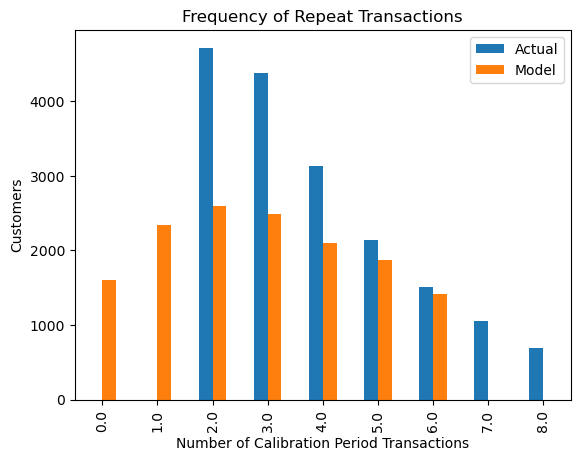

In [32]:
plot_period_transactions(bgf)
plt.show()

In [33]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [34]:
ggf.fit(cltv_df['frequency'],
        cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [35]:
cltv_df['exp_average_value'] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                       cltv_df['monetary'])

In [36]:
cltv_df.sort_values('exp_average_value', ascending=False).head()

,master_id,recency,T,frequency,monetary,exp_purchases_3_month,exp_purchases_6_month,exp_average_value
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857143,7.857143,4.0,1401.800000,1.094385,2.188769,1449.060468
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.714286,101.000000,7.0,1106.467143,0.722238,1.444476,1127.611525
15516,9083981a-f59e-11e9-841e-000d3a38a36f,63.571429,83.857143,4.0,1090.360000,0.574648,1.149296,1127.354466
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.285714,9.428571,2.0,862.690000,0.793924,1.587847,923.679965
16410,6fecd6c8-261a-11ea-8e1c-000d3a38a36f,57.000000,94.857143,2.0,859.580000,0.397362,0.794724,920.357946


In [37]:
# Calculate 6 months CLTV and add it to the dataframe with the name cltv.
cltv_df['cltv'] = ggf.customer_lifetime_value(bgf,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'],
                                              cltv_df['monetary'],
                                              time=6,      # 6 months
                                              freq='W',    # Frequency of T value, ['W']eekly
                                              discount_rate=0.01)

In [38]:
# 20 people with the highest CLTV value
cltv_df.sort_values('cltv', ascending=False).head(20)

,master_id,recency,T,frequency,monetary,exp_purchases_3_month,exp_purchases_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857143,7.857143,4.0,1401.800000,1.094385,2.188769,1449.060468,3327.777040
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.142857,13.142857,11.0,758.085455,1.970108,3.940216,767.360602,3172.394390
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.714286,101.000000,7.0,1106.467143,0.722238,1.444476,1127.611525,1708.982063
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.285714,74.571429,16.0,501.873750,1.565309,3.130618,506.166665,1662.613492
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714286,67.285714,52.0,166.224615,4.656138,9.312276,166.712253,1628.887381
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.428571,34.428571,8.0,601.226250,1.265456,2.530912,611.492616,1623.812684
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.285714,9.428571,2.0,862.690000,0.793924,1.587847,923.679965,1538.855906
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714286,13.000000,17.0,259.865294,2.780689,5.561378,262.072907,1529.227995
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.571429,58.714286,31.0,228.530000,3.083779,6.167558,229.606946,1485.819156
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.857143,15.571429,3.0,743.586667,0.871564,1.743128,778.050370,1422.999674


In [39]:
cltv_df['cltv_segment'] = pd.qcut(cltv_df['cltv'], 4, labels=['D', 'C', 'B', 'A'])

In [40]:
cltv_df.sort_values('cltv', ascending=False).head()

,master_id,recency,T,frequency,monetary,exp_purchases_3_month,exp_purchases_6_month,exp_average_value,cltv,cltv_segment
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857143,7.857143,4.0,1401.800000,1.094385,2.188769,1449.060468,3327.777040,A
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.142857,13.142857,11.0,758.085455,1.970108,3.940216,767.360602,3172.394390,A
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.714286,101.000000,7.0,1106.467143,0.722238,1.444476,1127.611525,1708.982063,A
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.285714,74.571429,16.0,501.873750,1.565309,3.130618,506.166665,1662.613492,A
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714286,67.285714,52.0,166.224615,4.656138,9.312276,166.712253,1628.887381,A


In [41]:
cltv_df['cltv_segment'].value_counts()

D    4987
C    4986
B    4986
A    4986
Name: cltv_segment, dtype: int64

In [42]:
cltv_df.groupby('cltv_segment').agg({'cltv': ['mean', 'min', 'max'],
                                     'frequency':['mean', 'min', 'max', 'sum'],
                                     'monetary':['mean', 'min', 'max', 'sum'],
                                     'recency':['mean', 'min', 'max']})

cltv                          frequency                        monetary                                        recency                 
                    mean         min          max      mean  min   max      sum        mean        min       max           sum        mean  min         max
cltv_segment                                                                                                                                               
D              80.340476   12.108003   112.245389  3.768799  2.0  18.0  18795.0   93.151603  22.490000   284.985  4.645470e+05  139.000172  0.0  432.571429
C             138.311508  112.248409   165.468859  4.404733  2.0  32.0  21962.0  125.788537  34.315556   342.840  6.271816e+05   92.629534  0.0  433.000000
B             199.532849  165.469210   240.057865  5.092659  2.0  50.0  25392.0  160.636574  50.042632   539.985  8.009340e+05   81.988367  0.0  415.571429
A             362.315501  240.085432  3327.777040  6.646611  2.0  57.0  33140.0  228.831142  64.364500  1401.800  1.140952e+06   67.427139  0.0  433.428571

In [43]:
cltv_df[['master_id', 'recency', 'T', 'frequency', 'monetary', 'cltv', 'cltv_segment']]

,master_id,recency,T,frequency,monetary,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000000,30.571429,5.0,187.874000,395.733234,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857143,224.857143,21.0,95.883333,199.430693,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.285714,78.857143,5.0,117.064000,170.224184,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571429,20.857143,2.0,60.985000,98.945526,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.142857,95.428571,2.0,104.990000,95.011659,D
...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41.142857,88.428571,3.0,133.986667,144.101715,C
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42.285714,65.285714,2.0,195.235000,212.440779,B
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88.714286,89.857143,3.0,210.980000,224.130773,B
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98.428571,113.857143,6.0,168.295000,221.078908,B
